# Song Genre Classification
## Part 1: Data Collection

### About:
- most data from  [AZLyrics Song Lyrics Dataset](https://www.kaggle.com/albertsuarez/azlyrics)
- rap lyrics from [Hip-Hop Encounters Data Science Dataset](https://www.kaggle.com/rikdifos/rap-lyrics
- folk + blues extra data from https://www.musixmatch.com
- genre classification from https://www.musixmatch.com

### Connect to musixmatch API

In [3]:
!pip install --quiet pymusixmatch

In [460]:
TOKEN = 'e95a15b62b47164882a8caed43b50749'

In [461]:
from musixmatch import Musixmatch


musixmatch = Musixmatch(TOKEN)

### Load data

In [98]:
import csv
import glob
from tqdm.auto import tqdm


def _get_csv_file_list(unzipping_output_folder):
    """
    Extract all the csv file paths given the folder path.
    :param unzipping_output_folder: Folder path.
    :return: List of CSV file paths.
    """
    csv_file_list = [i for i in glob.glob(f'{unzipping_output_folder}/**/*.csv')]
    print(f'{len(csv_file_list)} CSV files extracted.')
    return csv_file_list


def _read(csv_file_list):
    """
    Read the list of data CSVs.
    :param csv_file_list: List of CSV file paths where the data is.
    :return: CSVs read.
    """
    data = []
    total = 0
    for csv_file_name in tqdm(csv_file_list):
        with open(csv_file_name, 'r') as csv_file:
            rows = [row for row in csv.reader(csv_file) if row][1:]
            total += len(rows)
            data += rows
            print(f'{csv_file_name}: {len(rows)} songs.')
    print(f'Total: {total}')
    return data
            
            
data_folder = './'
csv_file_list = _get_csv_file_list(data_folder)
data = _read(csv_file_list)

27 CSV files extracted.


./azlyrics-scraper/azlyrics_lyrics_19.csv: 868 songs.
./azlyrics-scraper/azlyrics_lyrics_g.csv: 4542 songs.
./azlyrics-scraper/azlyrics_lyrics_p.csv: 5578 songs.
./azlyrics-scraper/azlyrics_lyrics_q.csv: 386 songs.
./azlyrics-scraper/azlyrics_lyrics_f.csv: 2450 songs.
./azlyrics-scraper/azlyrics_lyrics_d.csv: 6349 songs.
./azlyrics-scraper/azlyrics_lyrics_s.csv: 12703 songs.
./azlyrics-scraper/azlyrics_lyrics_r.csv: 3757 songs.
./azlyrics-scraper/azlyrics_lyrics_e.csv: 5414 songs.
./azlyrics-scraper/azlyrics_lyrics_v.csv: 1432 songs.
./azlyrics-scraper/azlyrics_lyrics_a.csv: 13046 songs.
./azlyrics-scraper/azlyrics_lyrics_w.csv: 4697 songs.
./azlyrics-scraper/azlyrics_lyrics_u.csv: 877 songs.
./azlyrics-scraper/azlyrics_lyrics_b.csv: 22672 songs.
./azlyrics-scraper/azlyrics_lyrics_c.csv: 10296 songs.
./azlyrics-scraper/azlyrics_lyrics_t.csv: 5157 songs.
./azlyrics-scraper/azlyrics_lyrics_y.csv: 1183 songs.
./azlyrics-scraper/azlyrics_lyrics_n.csv: 3052 songs.
./azlyrics-scraper/azlyric

In [123]:
import pandas as pd


data = pd.DataFrame(data)
data = data[[0, 1, 2, 3, 4]]

In [125]:
data = data.rename(columns={0:'author', 
                            1: 'author_url', 
                            2: 'song',
                            3: 'song_url',
                            4: 'lyrics'})

In [127]:
data.head()

,author,author_url,song,song_url,lyrics
0,03 greedo,https://www.azlyrics.com/19/03greedo.html,sweet lady,https://www.azlyrics.com/lyrics/03greedo/sweet...,"its only one, 03, i'm from grape street, where..."
1,03 greedo,https://www.azlyrics.com/19/03greedo.html,mafia business,https://www.azlyrics.com/lyrics/03greedo/mafia...,"you gonna make me put you in a suit and tie, s..."
2,03 greedo,https://www.azlyrics.com/19/03greedo.html,paranoid,https://www.azlyrics.com/lyrics/03greedo/paran...,"we could kill it, yeah, we could, we could, we..."
3,03 greedo,https://www.azlyrics.com/19/03greedo.html,never bend,https://www.azlyrics.com/lyrics/03greedo/never...,"yeah, you lil bitch ass niggas steady speaking..."
4,03 greedo,https://www.azlyrics.com/19/03greedo.html,prayer for my lost,https://www.azlyrics.com/lyrics/03greedo/praye...,"x loaded up bro, never see me in the church, p..."


In [189]:
data.to_csv('org_data.csv', index=False)

### Get genre classification

In [1]:
from langdetect import detect


def get_lang(lyrics):
    """
    detect the language of the song
    """
    try:
        lang = detect(lyrics[:100])
        return lang == 'en'
    except:
        pass
    

def get_genre(song):
    """
    get genre classification
    return False if genre is not in the list
    """
    genres = ['Pop', 'Rock', 'Rap', 'Blues', 'Country', 'Funk', 'Music']
    
    song = song['music_genre_list']
    song_genres = []
    for genre in song:
        g = genre['music_genre']['music_genre_name']
        if g in genres:
            song_genres.append(g)
    if len(song_genres) > 1 and song_genres[0] == 'Music':
        return song_genres[1]
    else:
        return song_genres[0] if len(song_genres) > 0 else False
    
    
def find_song(row): 
    """
    get genre of the song
    """
    song_data = musixmatch.track_search(q_track=row['song'],
                                        q_artist=row['author'], 
                                        page_size=1, 
                                        page=1, 
                                        s_track_rating='desc')
    try:
        song = song_data['message']['body']['track_list'][0]['track']['primary_genres']
        genre = get_genre(song)
        return genre
    except:
        pass

In [2]:
new_data = []

In [ ]:
banned_artists = ['2ne1']  # weird lyrics< we want to avoid them
i = 84428  # index of the last song collected: as the token allows only for 2000 queries a day
for ind, song in tqdm(data.loc[i:].iterrows(), total=len(data[i:])):
    if song['author'] not in banned_artists and get_lang(song['lyrics'][:100]):
        genre = find_song(song)
        if genre:
            new_data.append((song['author'], song['song'], song['lyrics'], genre))

In [197]:
len(new_data)

8993

In [198]:
COLUMNS = ['author', 'song', 'lyrics', 'genre']
clean_data = pd.DataFrame(new_data, columns=COLUMNS)

In [199]:
clean_data

,author,song,lyrics,genre
0,911,wonderland,"wey-oh, wey-oh, we'll be as one in wonder, won...",Rock
1,2 chainz,intro,"dj technik mixtape mastermind, trap check. tra...",Music
2,2 chainz,cowboy,"it's all the same, only the names will change,...",Music
3,2 chainz,too easy,", the shit to easy bro, its too fucking easy, ...",Music
4,2 chainz,gasolean,"see i be rocking truey and my belt by louie, i...",Music
...,...,...,...,...
8988,"richards, keith",big enough,"no time for weepin' baby, no tears need flow, ...",Rock
8989,"richards, keith",make no mistake,"make no mistake about it mm, but things ain't ...",Rock
8990,robin thicke,top of the world,"come on come on, now you feeling like a pimp, ...",Pop
8991,robin thicke,pressure,", say, the pressure's plain to see yea, writte...",Pop


In [200]:
clean_data.to_csv('./data/data_1.csv', index=False)

### Combine data

In [262]:
data = pd.read_csv('./data/data_1.csv')
extra_data = pd.read_csv('./data/data_2.csv')  # more loaded data

In [263]:
data = pd.concat([data, extra_data])

In [264]:
data

,author,song,lyrics,genre
0,911,wonderland,"wey-oh, wey-oh, we'll be as one in wonder, won...",Rock
1,2 chainz,intro,"dj technik mixtape mastermind, trap check. tra...",Music
2,2 chainz,cowboy,"it's all the same, only the names will change,...",Music
3,2 chainz,too easy,", the shit to easy bro, its too fucking easy, ...",Music
4,2 chainz,gasolean,"see i be rocking truey and my belt by louie, i...",Music
...,...,...,...,...
25647,lynn anderson,cry,"if your sweetheart sends a letter of goodbye, ...",Country
25648,lynn anderson,never ending song of love,"i've got a never ending love for you, from now...",Country
25649,lynn anderson,bedtime story,"i've told you almost every bedtime story, and ...",Country
25650,lynn anderson,reason to believe,"if i listened long enough to you, i'd find the...",Music


### Add more Rap, Folk and Blues song lyrics

In [427]:
def find_songs(artist='', page_num=1, primary_genre=''):
    """
    find songs by genre/artist
    """
    song_data = musixmatch.track_search(q_track='',
                                        q_artist=artist, 
                                        page_size=100, 
                                        page=page_num, 
                                        s_track_rating='desc')
    
    songs = song_data['message']
    songs = songs['body']
    data = []
    if len(songs) != 0:
        songs=songs['track_list']
        for song in songs:
            if song['track']['has_lyrics'] == 1:
                genre = primary_genre
                track_id = song['track']['track_id']
                lyrics = musixmatch.track_lyrics_get(track_id=track_id)['message']['body']
                if len(lyrics) != 0:
                    lyrics = lyrics['lyrics']['lyrics_body']
                    lyrics = lyrics.split('*******', maxsplit=1)[0].strip()  # data format 
                    data.append((song['track']['artist_name'].lower(), 
                                 song['track']['track_name'], 
                                 lyrics, 
                                 genre))
    return data

Lists of artists:

In [462]:
folk_artists = ['The Alamanac Singers', 'Ani DiFranco', 'Ben Harper', 'Bob Dylan', 'The Carter Family', 'Cat Stevens']
blues_artists = ['Sena Ehrhardt', 'Josh Smith', 'Philip Sayce', 
                 'Philip Sayce', 'Roy Rogers', 'Cootie Stark', 
                 'Melvin Taylor', 'Ron Thompson', 'Mike Wheeler', 
                 'Angela Strehli', 'Tony Spinner', 'Sean Chambers', 
                 'Henrik Freischlader', 'Ana Popovic']

In [463]:
extra_folk = []
for artist in tqdm(folk_artists):
    for i in range(100):
        extra_folk.extend(find_songs(artist=artist, page_num=i, primary_genre='Folk'))

In [464]:
extra_folk = pd.DataFrame(extra_folk, columns=COLUMNS).drop_duplicates(keep='first')
extra_folk

,author,song,lyrics,genre
0,the almanac singers,House Of The Rising Sun,There is a house in New Orleans\nThey call the...,Folk
1,the almanac singers,Which Side are You On?,"Come, all you good workers\nGood news to you I...",Folk
2,the almanac singers,Plow Under,"Remember when the AAA,\nKilled a million hogs ...",Folk
3,the almanac singers,Talking Union,"Now, if you want higher wages let me tell you ...",Folk
4,the almanac singers,"I Don't Want Your Millions, Mister (All I Want)","I don't want your millions, Mister,\nI don't w...",Folk
...,...,...,...,...
4837,cat stevens,Ceylon City - Stereo Version,I'm going home to the town where I was born\nW...,Folk
4838,cat stevens,A Bad Penny - Live,Oh dont say those same idle lies\nI've heard t...,Folk
4839,cat stevens,Don't Be Shy (alternate version),"Don't be shy, just let your feelings roll on b...",Folk
4840,simtech productions feat. yusuf / cat stevens,Our Guide Is the Quraan (feat. Yusuf Islam),All Muslims have to do five things\nWho knows ...,Folk


In [466]:
extra_blues = []
for artist in tqdm(blues_artists):
    for i in range(50):
        extra_blues.extend(find_songs(artist=artist, page_num=i, primary_genre='Blues'))

In [467]:
extra_blues = pd.DataFrame(extra_blues, columns=COLUMNS)
extra_blues = extra_blues.drop_duplicates(keep='first')
extra_blues

,author,song,lyrics,genre
0,sena ehrhardt,On the Clock,Every day's our new chance to get it right in ...,Blues
1,sena ehrhardt,Buried Alive,"Ich kann nicht schlafen, ich kann nicht atmen,...",Blues
4,disero feat. josh smith,Like That,When we had that feeling\nThe stars were our c...,Blues
5,josh powell feat. fraser smith,Always,I believe in the light I've seen\nAnd the life...,Blues
6,josh powell feat. fraser smith,Leave Me as You Find Me,All ready for letting go\nNothing left to remi...,Blues
...,...,...,...,...
514,ana popovic,Soulful Dress,I'm gonna put on my dress\nWith that slip way ...,Blues
515,ana popovic & milton popovic,Evening Shadows,When evening shadows fall\nMinutes seem so lon...,Blues
516,ana popovic,Mended,You crushed my world\nThe day you went away.\n...,Blues
517,ana popovic,Minute 'Till Dawn,If we look back on time gone past\nBad moves b...,Blues


In [483]:
data = pd.concat([data, extra_folk, extra_blues], ignore_index=True)

Get rap lyrics:

In [484]:
rap = os.listdir('./rap_lyrics')

rap_data = []
for file in tqdm(rap):
    if file.endswith('.txt'):
        with open('./rap_lyrics/'+file, encoding='utf-8') as fid:
            text = fid.read()
        artist = file.strip('_lyrics.txt').replace('_', ' ').lower()
        songs = text.split('\n\n')
        for i, song in enumerate(songs):
            rap_data.append((artist, f'unk{i}', song, 'Rap'))

In [485]:
len(rap_data)

10262

In [486]:
data = data[data['genre'] != 'Rap']  # to avoid duplicates

In [487]:
rap_data = pd.DataFrame(rap_data, columns=COLUMNS)
data = pd.concat([data, rap_data], ignore_index=True).drop_duplicates(keep='first')

In [488]:
data

,author,song,lyrics,genre
0,911,wonderland,"wey - oh , wey - oh , we 'll be as one in wond...",Rock
1,2 chainz,intro,"dj technik mixtape mastermind , trap check . t...",Music
2,2 chainz,cowboy,"it 's all the same , only the names will chang...",Music
3,2 chainz,too easy,", the shit to easy bro , its too fucking easy ...",Music
4,2 chainz,gasolean,"see i be rocking truey and my belt by louie , ...",Music
...,...,...,...,...
45432,childish gambino,unk277,Ba-b-ba-b-ba-ba\nDuh-d-duh-duh-d-duh\nDuh-duh-...,Rap
45433,childish gambino,unk278,"Childish Gambino, lame niggas never heard of i...",Rap
45434,childish gambino,unk279,Runnin’ through the moment as the sun goes dow...,Rap
45435,childish gambino,unk280,"Gambeezy make it work somethin’, let me check ...",Rap


In [489]:
data.genre.value_counts()

Pop        11987
Rock       11311
Rap        10262
Country     5307
Folk        4366
Music       1541
Blues        644
Funk          19
Name: genre, dtype: int64

### Part 2: Preprocessing
#### Tokenization

In [3]:
import pandas as pd

In [24]:
data = pd.read_csv('./RS/data/final_data.csv')

In [25]:
data

,subset,author,song,genre,lyrics,tokenized,length,mean_depth
0,tr,chance the rappe,unk228,Rap,Another weekend full of blunts and brews\nToo ...,Another weekend full of blunts and brews \n To...,166,68.000000
1,tr,megan & liz,love war,Country,"i do n't believe in wizards or witches , but b...","i do n't believe in wizards or witches , but b...",210,13.200000
2,tr,jamiroquai,"if i like it, i do it",Pop,"if i like it i just do it , say that we have a...","if i like it i just do it , say that we have a...",332,29.750000
3,tr,drake,unk172,Rap,Done sayin' I'm done playin'\nLast time was on...,Done sayin ' I 'm done playin ' \n Last time w...,271,33.666667
4,tr,j cole,unk152,Rap,This next three bars is dedicated to the retar...,This next three bars is dedicated to the retar...,121,48.000000
...,...,...,...,...,...,...,...,...
20577,te,tyler the creato,unk103,Rap,"""Can't they just be happy for me like, a kid w...",""" Ca n't they just be happy for me like , a ki...",152,4.909091
20578,te,talib kwe,unk54,Rap,To the mothers (they neglected) to the fathers...,To the mothers ( they neglected ) to the fathe...,220,83.000000
20579,te,nitty gritty dirt band,you don't know my mind,Country,honey you do n't know my mind i 'm lonesome al...,honey you do n't know my mind i ' m lonesome a...,194,69.000000
20580,te,"martin, ricky",vida,Pop,"finally the time has come , let 's just dance ...","finally the time has come , let 's just dance ...",368,131.000000


In [26]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

In [27]:
def preprocess(text):
    """
    tokenize text
    """
    return ' '.join([token.text for token in nlp(text)])

In [28]:
data['tokenized'] = data['lyrics'].apply(preprocess)

#### Cleaning data:
- dropping None values
- dropping Funk songs (as there is too little of them)
- dropping songs with lyrics length < 20 words

In [29]:
data = data.drop_duplicates('tokenized', keep='first').dropna()
data = data[~data['genre'].isin(['Funk', 'Music'])]

In [30]:
def get_length(song):
    try:
        length = len(song.split())
    except AttributeError:
        length = 0 
    return length

In [31]:
data['length'] = data['tokenized'].apply(get_length)

In [34]:
data = data[data['length'] > 20]

Order columns

In [40]:
data = data[['author', 'song', 'lyrics', 'genre', 'tokenized', 'length']]
data

,author,song,lyrics,genre,tokenized,length
0,chance the rappe,unk228,Another weekend full of blunts and brews\nToo ...,Rap,Another weekend full of blunts and brews \n To...,166
1,megan & liz,love war,"i do n't believe in wizards or witches , but b...",Country,"i do n't believe in wizards or witches , but b...",210
2,jamiroquai,"if i like it, i do it","if i like it i just do it , say that we have a...",Pop,"if i like it i just do it , say that we have a...",332
3,drake,unk172,Done sayin' I'm done playin'\nLast time was on...,Rap,Done sayin ' I 'm done playin ' \n Last time w...,271
4,j cole,unk152,This next three bars is dedicated to the retar...,Rap,This next three bars is dedicated to the retar...,121
...,...,...,...,...,...,...
20577,tyler the creato,unk103,"""Can't they just be happy for me like, a kid w...",Rap,""" Ca n't they just be happy for me like , a ki...",152
20578,talib kwe,unk54,To the mothers (they neglected) to the fathers...,Rap,To the mothers ( they neglected ) to the fathe...,220
20579,nitty gritty dirt band,you don't know my mind,honey you do n't know my mind i 'm lonesome al...,Country,honey you do n't know my mind i ' m lonesome a...,194
20580,"martin, ricky",vida,"finally the time has come , let 's just dance ...",Pop,"finally the time has come , let 's just dance ...",368


### Split to train/test
<code>GroupKFold</code> to ensure ther is no artist overlap between splits => avoid overfitting as artists are typically prone to one particular genre

In [79]:
from sklearn.utils import shuffle
from sklearn.model_selection import GroupKFold, train_test_split
import numpy as np


group_kfold = GroupKFold(n_splits=2)
columns = data.columns.tolist()#['author', 'song', 'lyrics', 'genre', 'tokenized', 'length']


def get_sample(data, subset, col):
    for subset_ind, other_ind in group_kfold.split(data, groups=data[col]):
        X_subset, X_other = np.array(data)[subset_ind], np.array(data)[other_ind]
    subset.extend(X_subset)
    return subset, X_other



def split_data(data, col, coef, columns=columns):
    train, test = [], []
    train, left = get_sample(data, train, col=col)
    while len(train)/len(data) < coef:
        left = pd.DataFrame(left, columns=columns)
        train, left = get_sample(left, train, col=col)
    else:
        left = pd.DataFrame(left, columns=columns)
        test, dev = get_sample(left, test, col=col)
    return train, test, dev

In [80]:
train, test, dev = split_data(data, col='author', coef=0.7, columns=columns)

In [81]:
train = pd.DataFrame(train, columns=columns)
train['subset'] = 'tr'

In [82]:
test = pd.DataFrame(test, columns=columns)
test['subset'] = 'te'

In [83]:
dev = pd.DataFrame(dev, columns=columns)
dev['subset'] = 'va'

In [84]:
train.genre.value_counts()

Rap        4345
Country    3444
Rock       2675
Folk       2476
Pop        2113
Blues       385
Name: genre, dtype: int64

In [85]:
test.genre.value_counts()

Rap        1031
Country     704
Pop         514
Rock        265
Folk         35
Blues        24
Name: genre, dtype: int64

In [86]:
dev.genre.value_counts()

Country    760
Rap        605
Rock       429
Folk       419
Pop        302
Blues       57
Name: genre, dtype: int64

#### Balance classes

In [87]:
data = pd.concat([train, test, dev], ignore_index=True)

In [99]:
data = data[['subset', 'author', 'song', 'lyrics', 'genre', 'tokenized', 'length']]
data

,subset,author,song,lyrics,genre,tokenized,length
0,tr,bob dylan,Black Cross (Live),This is the story of Hezekiah Jones...\n\nHeze...,Folk,This is the story of Hezekiah Jones ... \n\n H...,144
1,tr,isaiah rashad,unk174,"My niggas die for it, she got that pussy juice...",Rap,"My niggas die for it , she got that pussy juic...",107
2,tr,jamie lawson,a darkness,"there 's a darkness in between us , a darkness...",Pop,"there 's a darkness in between us , a darkness...",363
3,tr,aap rock,unk83,Tell me why these little niggas talking like t...,Rap,Tell me why these little niggas talking like t...,110
4,tr,"pointer sisters, the",shut up and dance,"hey you , you wanna dance ? , all i want to do...",Pop,"hey you , you wanna dance ? , all i want to do...",508
...,...,...,...,...,...,...,...
20578,va,roy rogers & dale evans,Cool Water,Cool Water\nAll day I faced the barren waste\n...,Blues,Cool Water \n All day I faced the barren waste...,72
20579,va,roy rogers & dale evans,Home on the Range,"Oh, give me a home where the buffalo roam\nWhe...",Blues,"Oh , give me a home where the buffalo roam \n ...",61
20580,va,roy rogers & dale evans,Remember Whose Birthday It Is / Happy Birthday...,Happy birthday to you ...\nThis is for you\nI ...,Blues,Happy birthday to you ... \n This is for you \...,22
20581,va,roy rogers & dale evans,Happy Trails,"Happy trails to you, until we meet again\nHapp...",Blues,"Happy trails to you , until we meet again \n H...",49


### Visualization

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

style.use('seaborn')

In [91]:
def plot_train_test(data):
    bins = [data[data['subset']==i].count()['length'] for i in ['tr', 'te', 'va']]
    plt.pie(bins, labels=['tr', 'te', 'va'], autopct='%1.1f%%')

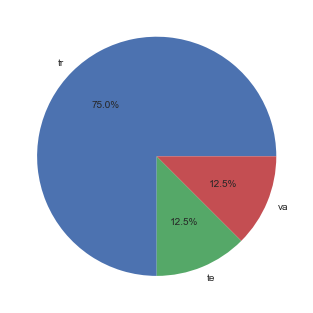

In [92]:
plot_train_test(data)

In [93]:
def plot_feature(data, feature):
    classes = set(data[feature].to_list())

    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i, sub in enumerate(['tr', 'te', 'va', 'all']):
        if sub == 'all':
            bins = [data[data[feature] == j].count()['length'] for j in classes]
        else:
            bins =  [data[(data[feature] == j) & 
                          (data['subset'] == sub)
                          ].count()['length'] for j in classes]

        axs[0][i].bar(range(len(classes)), bins)
        axs[0][i].set_title('Subject distribution in {} data'.format(sub))
        axs[1][i].pie(bins, labels=classes, autopct='%1.1f%%')

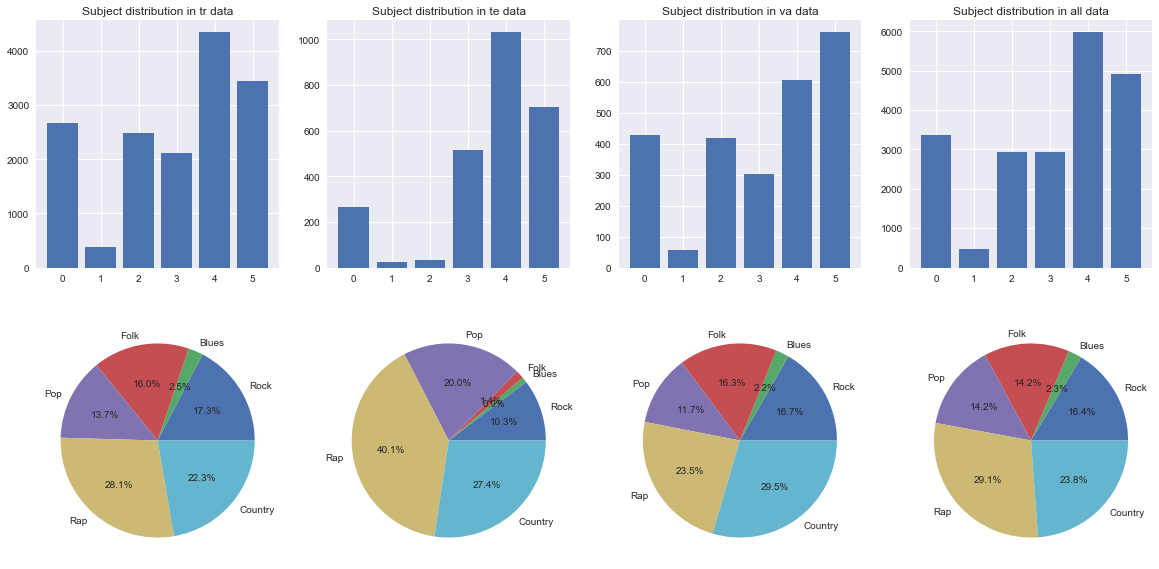

In [94]:
plot_feature(data, 'genre')

In [95]:
def plot_dist(data, feature, name):
    """
    plot distribution of sentence length feature
    """
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    
    for i, sub in enumerate(['tr', 'te', 'va', 'all']):
        if sub == 'all':
            df = data[feature]
        else:
            df = data[data['subset']==sub][feature]

        sns.distplot(df, bins=20, color='green', ax=axs[i])
        axs[i].axvline((df).mean(), 
                        color='k', 
                        linestyle='dashed', 
                        linewidth=1, 
                        label='mean')
        axs[i].axvline((df).median(), 
                        color='b', 
                        linestyle='dashed', 
                        linewidth=1, 
                        label='median')
        axs[i].legend()
        axs[i].set(title="{} distribution in {} data, {}".format(feature,sub,name))
    plt.show()

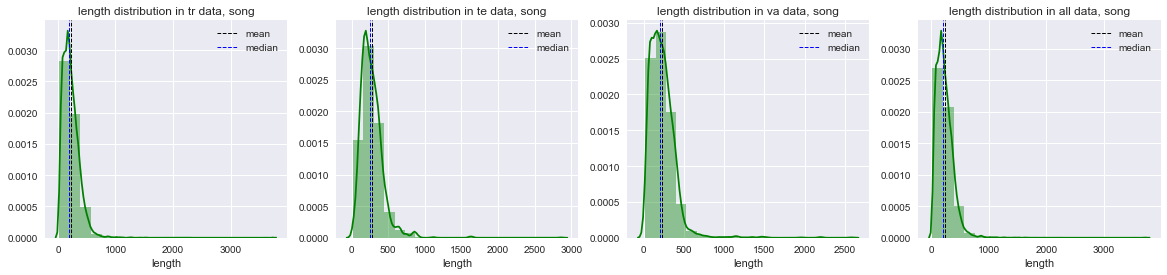

In [96]:
plot_dist(data, 'length', 'song')

In [100]:
data.to_csv('./RS/data/final_data.csv', index=False)